<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/MobileNet_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
import urllib
import re

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
IMG_SIZE = 96
def make_square(im, min_size=IMG_SIZE):
    x, y = im.size
    fill_color = im.getpixel((x-1, y-1))
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return np.asarray(new_im)

In [0]:
original_folder = "/content/drive/My Drive/Colab Notebooks/immagini_originali"

original_images = []
names = []
for file in os.listdir(original_folder):
  family = re.sub("stemma |.gif", "", re.sub("%20|%2520", " ", file.lower()))
  names.append(family)
  file_path = os.path.join(original_folder, file)
  array = make_square(Image.open(file_path).convert("RGB"))
  original_images.append(array)

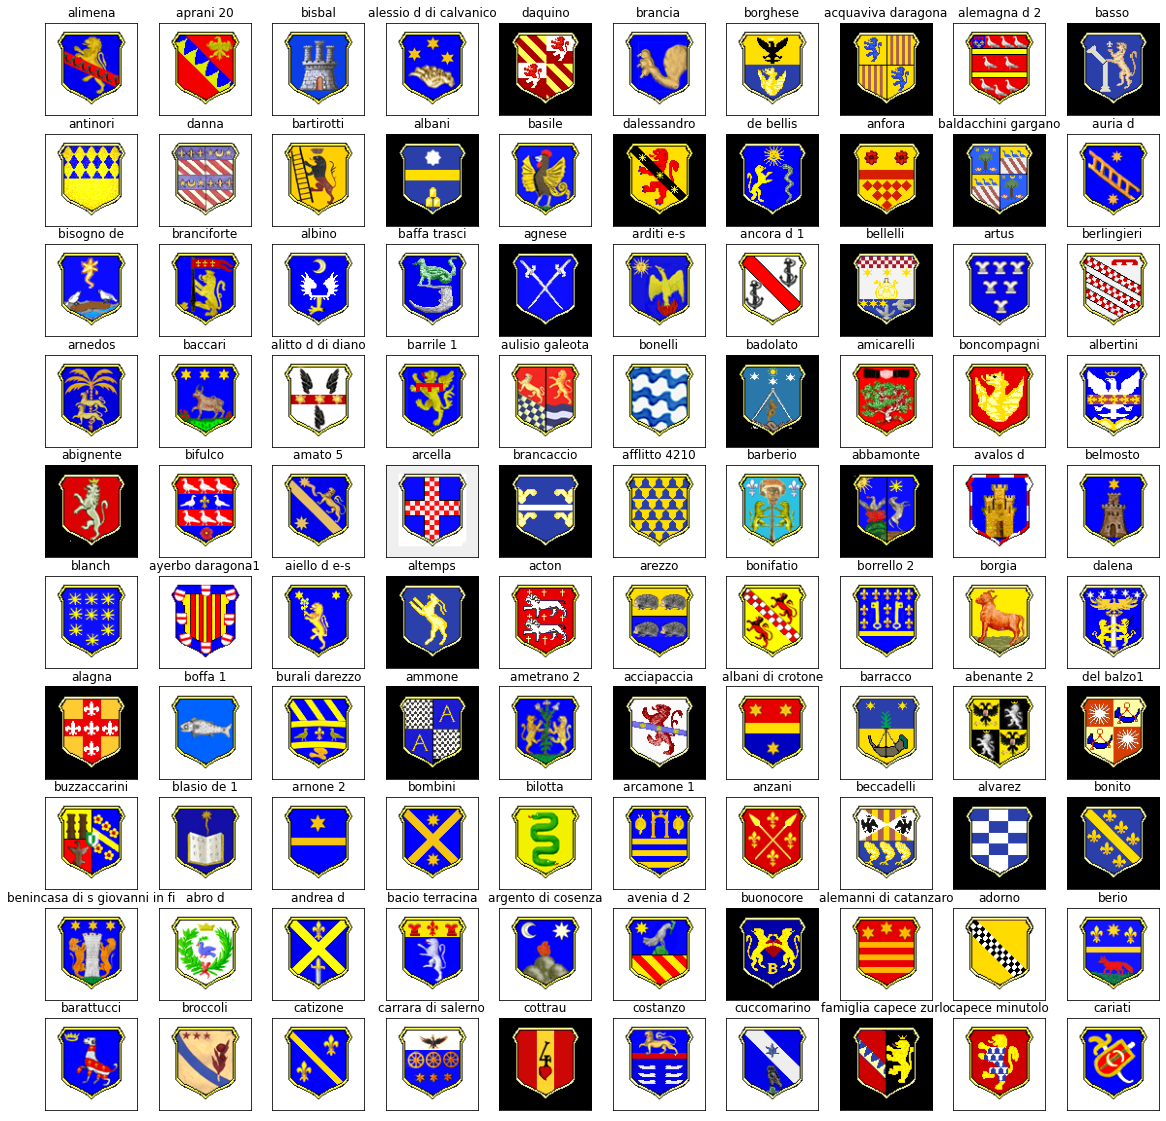

In [6]:
fig, ax_mat = plt.subplots(10, 10, figsize=(20, 20))
axs = np.ravel(ax_mat)
for i in range(100):
  axs[i].imshow(original_images[i])
  axs[i].set(title=names[i], xticks=[], yticks=[])
  
plt.show()

In [0]:
from sklearn.preprocessing import OneHotEncoder
original_labels = tf.keras.utils.to_categorical(range(len(original_images)))
norm_images = np.asarray(original_images)/127.5 -1

cloned_images = np.repeat(norm_images, 30, axis=0)
cloned_labels = np.repeat(original_labels, 30, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


aprani 20


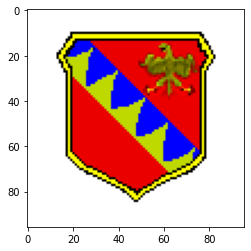

In [14]:
#example
plt.imshow(cloned_images[50])
print(names[np.argmax(cloned_labels[50])])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test \
    = train_test_split(cloned_images, cloned_labels, test_size=0.2, random_state=1)

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
# Let's take a look at the base model architecture
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [0]:
prediction_layer = tf.keras.layers.Dense(584, activation="softmax")

In [0]:
with tf.device("/gpu:0"):
  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
  ])

In [0]:
base_learning_rate = 0.0001
with tf.device("/gpu:0"):
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 584)               748104    
Total params: 3,006,088
Trainable params: 748,104
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
!nvidia-smi
print(tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Mon Apr 27 13:46:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W /  75W |    235MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7899029984194189111, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3217556217276612444
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1743766591761555387
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7304675328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 287058277665695017
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [26]:
with tf.device("/gpu:0"):
  history = model.fit(x=X_train, y=Y_train,
                      epochs=50,
                      validation_size=0.35)

Epoch 1/50
438/438 [==============================] - 7s 16ms/step - loss: 0.6940 - accuracy: 0.0382
Epoch 2/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6939 - accuracy: 0.1662
Epoch 3/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6937 - accuracy: 0.3146
Epoch 4/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6935 - accuracy: 0.4205
Epoch 5/50
438/438 [==============================] - 7s 16ms/step - loss: 0.6933 - accuracy: 0.4950
Epoch 6/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6932 - accuracy: 0.5616
Epoch 7/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6931 - accuracy: 0.6120
Epoch 8/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6931 - accuracy: 0.6732
Epoch 9/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6930 - accuracy: 0.7095
Epoch 10/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6929 - accura

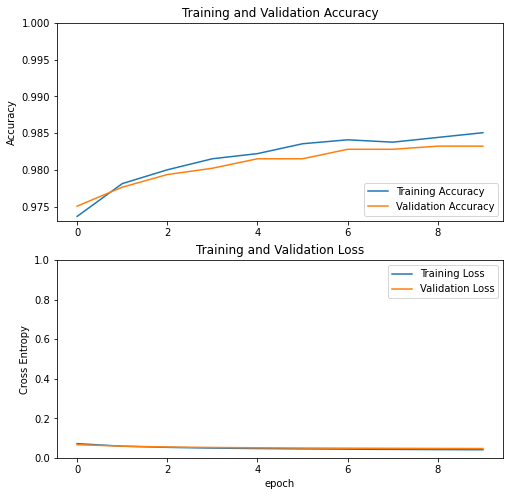

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()